# Import Libraries

In [47]:
'''Import libraries'''
import pandas as pd
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cross_validation import train_test_split
from sklearn.linear_model import LogisticRegression, RidgeClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
import lightgbm as lgb
from sklearn.metrics import precision_score, recall_score, confusion_matrix, classification_report,confusion_matrix
from sklearn.metrics import average_precision_score, roc_curve, precision_recall_curve, fbeta_score, f1_score
from imblearn.over_sampling import SMOTE
from collections import Counter
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


# Importing Data

In [48]:
data = pd.read_csv("creditcard.csv")
data.head()
try:
    data = pd.read_csv("creditcard.csv")
    print(("Credit Card dataset has {} samples with {} features each.").format(*data.shape))
except:
    print( "Dataset could not be loaded. Is the dataset missing?")

Credit Card dataset has 284807 samples with 31 features each.


***View Data***

In [49]:
data.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


# Data Exploration

***View Binary Class Distribution***

Total records count  284807
Fraud records count  492
Non Fraud records count  284315


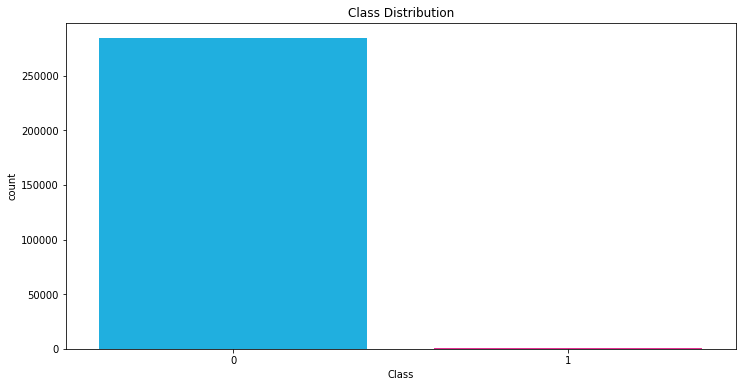

In [50]:
total_count = data.Class.count()
frauds_count = data.Class[data.Class == 1].count()
non_fraud_counts = data.Class[data.Class == 0].count()

print("Total records count  {}".format(total_count))
print("Fraud records count  {}".format(frauds_count))
print("Non Fraud records count  {}".format(non_fraud_counts))

#Graph
my_palette = {0: 'deepskyblue', 1: 'deeppink'}

plt.figure(figsize = (12, 6))
sns.countplot(x = 'Class', data = data, palette = my_palette)
plt.title('Class Distribution')
plt.show()

*** Clearly the dataset is highly unbalanced. Out of nearly 300k transaction there are under 500 fradualent transactions***

### Review how transaction amount differs for the 2 classes

In [51]:
data.Amount[data.Class==1].describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [52]:
data.Amount[data.Class==0].describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

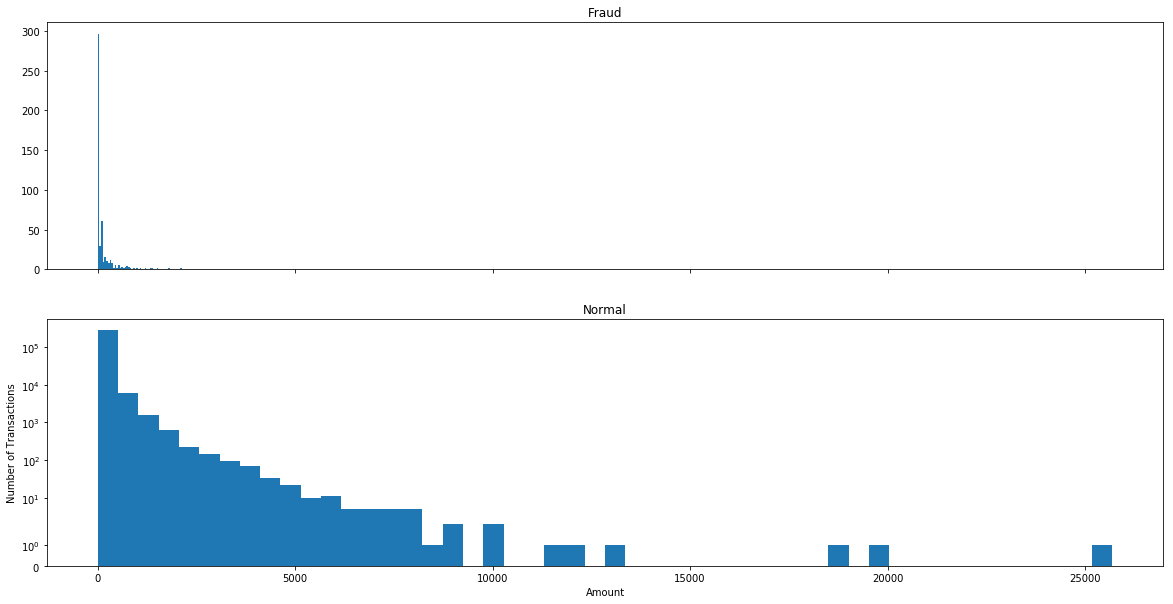

In [53]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,10))

bins = 50

ax1.hist(data.Amount[data.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(data.Amount[data.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.yscale('symlog')
plt.show()

Most of the Fraduent transactions are low value as compared to non fraulent transactionns.The maximum amount for a fraudulent ransaction 2,125.

### Explore the time vs amount

In [54]:
# Time between subsequent transactions in hrs
data['time_hrs']= data.Time/3600

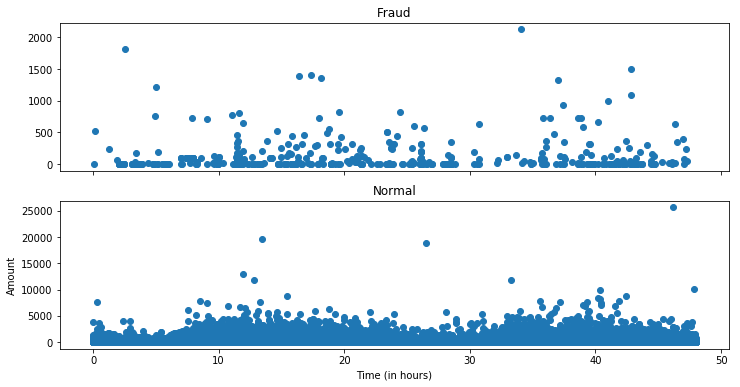

In [55]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(12,6))


ax1.scatter(data.time_hrs[data.Class == 1], data.Amount[data.Class == 1])
ax1.set_title('Fraud')

ax2.scatter(data.time_hrs[data.Class == 0], data.Amount[data.Class == 0])
ax2.set_title('Normal')

plt.xlabel('Time (in hours)')
plt.ylabel('Amount')
plt.show()

There is no significant reading from above plot

In [56]:
### Plot no. of trasactions over time

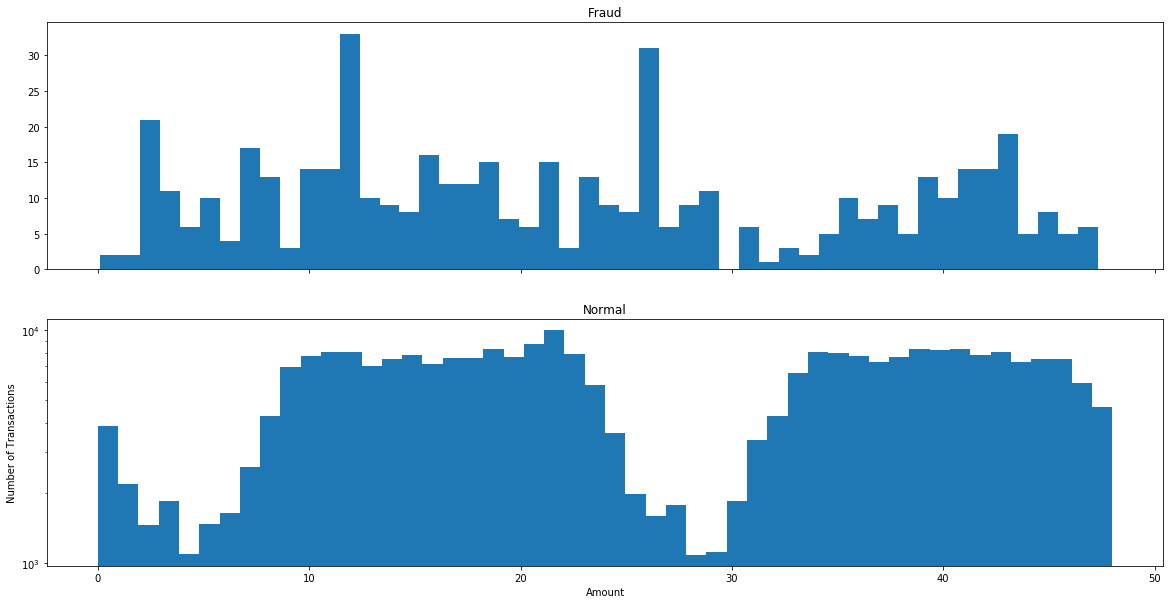

In [57]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True, figsize=(20,10))

bins = 50

ax1.hist(data.time_hrs[data.Class == 1], bins = bins)
ax1.set_title('Fraud')

ax2.hist(data.time_hrs[data.Class == 0], bins = bins)
ax2.set_title('Normal')

plt.xlabel('Amount')
plt.ylabel('Number of Transactions')
plt.yscale('log')
plt.show()

***Normal transactions tend to go down between near 01 to 10th hr and  24th to 34th hour indicating cyclic trend but the same is not being displayed by the fraudulent transactions. This may help in detetcion of fraudulent transactions during these hours.***

# Data Prepration

***Separate features and labels***

In [58]:
features  = data.drop(["Class"],axis=1)
label = data.Class

*** Split into train and test data***

In [59]:
def get_train_test_data(X,y):
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=.3)
    return(X_train,X_test,y_train,y_test)

X_train, X_test , y_train, y_test =get_train_test_data(features,label)

print("\nDisplay Split Dataset Summary...")
print("Orignal set has {} samples'".format(features.shape[0]))
print('Training set has {} samples'.format(X_train.shape[0]))
print('Testing set has {} samples'.format(X_test.shape[0]))


Display Split Dataset Summary...
Orignal set has 284807 samples'
Training set has 199364 samples
Testing set has 85443 samples


# Mulitple Models Evaluation -with Precision Recall Metrics

##### Specific function defined for setting up params and data for Ligh Gradient Boosting model

In [63]:
def LGB(d_train):
    params = {}
    params['learning_rate'] = 0.0003
    params['boosting_type'] = 'gbdt'
    params['objective'] = 'binary'
    params['metric'] = 'binary_logloss'
    params['sub_feature'] = 0.5
    params['num_leaves'] = 100
    params['min_data'] = 10
    params['max_depth'] = 1000
    clf = lgb.train(params, d_train, 100)
    return clf

## Functions to train and test mutliple clssifiers

In [15]:
# Train & evaluate the models
def train_predict(clf, X_train, y_train, X_test, y_test): 
    '''
    inputs:
       - learner: the learning algorithm to be trained and predicted on
       - sample_size: the size of samples (number) to be drawn from training set
       - X_train: features training set
       - y_train: income training set
       - X_test: features testing set
       - y_test: income testing set
    '''
    results = {}
    
    clf_name = clf.__class__.__name__ 
    if clf == 'Booster': #LGB
        clf_name = 'Booster'
        d_train = lgb.Dataset(X_train, label=y_train)
        start = time() # Get start time
        clf = LGB(d_train)
        end = time() # Get end time
    else:    
        start = time() # Get start time
        clf = clf.fit(X_train,y_train)
        end = time() # Get end time
    
    # Calculate the training time
    results['train_time'] = end -start
     
    start = time() # Get start time
    # Get the predictions on the test set(X_test),
    y_pred = clf.predict(X_test)
    end = time() # Get end time
    results['test_time'] = end -start
    # Calculate Peformance
    results['precision'] = precision_score(y_test, y_pred.round())
    results['recall'] = recall_score(y_test, y_pred.round())   
    if not clf_name =='Booster':
        y_pred = clf.decision_function(X_test)
    results['AUPRC']  = average_precision_score(y_test,y_pred)

    print("{} trained on   samples.".format(clf.__class__.__name__))
        
    # Return the results
    return results


def test(class_weight= {0: 1., 1: 1.}):
    # Initialize the three models
    clf_A = AdaBoostClassifier(random_state =10)
    clf_B = RidgeClassifier(random_state=10,class_weight=class_weight)
    clf_C = LogisticRegression(random_state =10,class_weight=class_weight)
    clf_D = 'Booster'
    if class_weight== {0: 1., 1: 1.}:
        clf_list = [clf_A, clf_B, clf_C, clf_D]
    else:
        clf_list = [clf_B, clf_C]
    
    # Collect results on the learners
    results = {}
    for clf in clf_list:
        if clf == clf_D:
            clf_name = clf
        else:
            clf_name = clf.__class__.__name__           
        results[clf_name] = \
        train_predict(clf, X_train, y_train, X_test, y_test)
        results[clf_name]['class_weight']= class_weight
    return results

***Evaluate multiple models without applying class weights***

In [24]:
results = test()
results

AdaBoostClassifier trained on   samples.
RidgeClassifier trained on   samples.
LogisticRegression trained on   samples.
Booster trained on   samples.


{'AdaBoostClassifier': {'train_time': 61.87954330444336,
  'test_time': 0.7560102939605713,
  'precision': 0.8248175182481752,
  'recall': 0.7635135135135135,
  'AUPRC': 0.8242386771977751,
  'class_weight': {0: 1.0, 1: 1.0}},
 'RidgeClassifier': {'train_time': 0.377002477645874,
  'test_time': 0.007020473480224609,
  'precision': 0.8133333333333334,
  'recall': 0.41216216216216217,
  'AUPRC': 0.7658420287399721,
  'class_weight': {0: 1.0, 1: 1.0}},
 'LogisticRegression': {'train_time': 4.086866140365601,
  'test_time': 0.008020401000976562,
  'precision': 0.7164179104477612,
  'recall': 0.6486486486486487,
  'AUPRC': 0.6019459958005489,
  'class_weight': {0: 1.0, 1: 1.0}},
 'Booster': {'train_time': 4.181119918823242,
  'test_time': 0.6126284599304199,
  'precision': 0.9516129032258065,
  'recall': 0.7972972972972973,
  'AUPRC': 0.882010464364217,
  'class_weight': {0: 1.0, 1: 1.0}}}

***Evaluate and observe results after applying class weights (Appliacble to Logistic regression and ridge classifier)***

In [27]:
class_weight = {0: 1., 1: 9.9}
results = test(class_weight)
results

RidgeClassifier trained on   samples.
LogisticRegression trained on   samples.


{'RidgeClassifier': {'train_time': 0.36095690727233887,
  'test_time': 0.00701904296875,
  'precision': 0.8627450980392157,
  'recall': 0.5945945945945946,
  'AUPRC': 0.7706538611062957,
  'class_weight': {0: 1.0, 1: 9.9}},
 'LogisticRegression': {'train_time': 7.0487425327301025,
  'test_time': 0.00902557373046875,
  'precision': 0.7530120481927711,
  'recall': 0.8445945945945946,
  'AUPRC': 0.7814126401265683,
  'class_weight': {0: 1.0, 1: 9.9}}}

### Conclusions from initial runs

***1. Light Gradient Boosting with AUPRC score of .8820 performs much better than any other models and is pretty efficient.***
***2. Adaboost and Ridge classifiers perform much better than the benchmark model(Logistic regression) out of the box.*** 
***3. Applying weightage to the fraudalent class dramatically improves the performance of logistic regression model with minor improvment in ridge classifier 3.Adaboost is computationally expensive/slow***

# Working on the challenge of unbalanced datset

We have already tried penalizing the dominating class by using class weights. We can now further try and improve results by using resampling the training data using oversampling oe undersampling techniques.
I'm focussing on resampling by oversampling the minority class by using a technique called SMOTE(Synthetic Minority Over-Sampling Technique)

In [79]:
sm = SMOTE(random_state=42)
X_res, y_res = sm.fit_sample(features, label)
print('Resampled dataset shape {}'.format(Counter(y_res)))

Resampled dataset shape Counter({0: 284315, 1: 284315})


In [80]:
#Split resampled data into training and testing sets
X_train, X_test , y_train, y_test =get_train_test_data(X_res,y_res)

## Testing on Oversampled dataset - Compare Adaboost,Ridge and Logistic regression with each other 

In [65]:
# Run multiple models on oversampled data
results = test()
results

AdaBoostClassifier trained on   samples.
RidgeClassifier trained on   samples.
LogisticRegression trained on   samples.
Booster trained on   samples.


{'AdaBoostClassifier': {'train_time': 163.98775172233582,
  'test_time': 2.3333115577697754,
  'precision': 0.9876554865815376,
  'recall': 0.9781320492291868,
  'AUPRC': 0.9985995010510701,
  'class_weight': {0: 1.0, 1: 1.0}},
 'RidgeClassifier': {'train_time': 1.078866720199585,
  'test_time': 0.031083106994628906,
  'precision': 0.9874624664173207,
  'recall': 0.8763543285919658,
  'AUPRC': 0.9885462991220754,
  'class_weight': {0: 1.0, 1: 1.0}},
 'LogisticRegression': {'train_time': 15.254562377929688,
  'test_time': 0.013032674789428711,
  'precision': 0.9831762796443885,
  'recall': 0.9487371287649459,
  'AUPRC': 0.9931788735908442,
  'class_weight': {0: 1.0, 1: 1.0}},
 'Booster': {'train_time': 9.450867891311646,
  'test_time': 1.4739196300506592,
  'precision': 0.9977622808159979,
  'recall': 0.984957748454283,
  'AUPRC': 0.9992147216179208,
  'class_weight': {0: 1.0, 1: 1.0}}}

***Evaluate and observe results after applying class weights (Appliacble to Logistic regression and ridge classifier)***

In [16]:
# Applying class weights on Logistic regression and ridge classifier
class_weight = {0: 1., 1: 5}
results = test(class_weight)
results

RidgeClassifier trained on   samples.
LogisticRegression trained on   samples.


{'RidgeClassifier': {'train_time': 0.4582173824310303,
  'test_time': 0.009024381637573242,
  'precision': 0.8588235294117647,
  'recall': 0.5488721804511278,
  'AUPRC': 0.7454266547054786,
  'class_weight': {0: 1.0, 1: 5}},
 'LogisticRegression': {'train_time': 7.5230042934417725,
  'test_time': 0.007052183151245117,
  'precision': 0.7786259541984732,
  'recall': 0.7669172932330827,
  'AUPRC': 0.7441962790430269,
  'class_weight': {0: 1.0, 1: 5}}}

## Light Gradient Boosting(LGB) - BEST MODEL

### AUPRC Curve

Text(0.5,1,'2-class Precision-Recall curve: AP=0.9992')

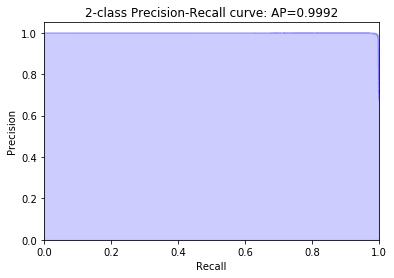

In [68]:
#Plotting AUPRC for the BEST Model
precision = results['Booster']['precision']
recall = results['Booster']['recall']
AUPRC = results['Booster']['AUPRC']
precision, recall, _ = precision_recall_curve(y_test, y_pred)
plt.step(recall, precision, color='b', alpha=0.2,
         where='post')
plt.fill_between(recall, precision, step='post', alpha=0.2,
                 color='b')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.4f}'.format(
          AUPRC))

### Plotting confusion Matrix

In [82]:
# Train and Test LGB Model only to get the confudion matrix
d_train = lgb.Dataset(X_train, label=y_train)
clf = LGB(d_train)
y_pred = clf.predict(X_test)
AUPRC_lgb = average_precision_score(y_test,y_pred)
AUPRC_lgb

0.9992811394919722

Confusion matrix, without normalization
[[85160   170]
 [ 1303 83956]]


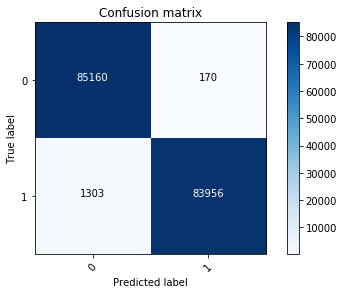

In [84]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, y_pred.round())
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['0', '1'],
                      title='Confusion matrix')

plt.show()

***Overall Conclusion - *** 
1. LGB or Light Gradient Boosting model performs the best over this unbalanced dataset followed by Adaboost,Ridge and Logistic regression.
2. Applying class weights help improving performance of logistc regression, still the performance lags LGB and Adaboost classifiers
3. Oversampling the data using SMOTE really helps in improving the results significantly - Again LGB performs the best followed by Adaboost.
4. After all experiments it can be concluded that ***LGB model*** should be selected and applied ***on oversampled(SMOTE) data*** which gives an ***AUPRC of 0.9992***